In [1]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from utils import * # tic toc imshow

import higra as hg

Image size: (481, 321)


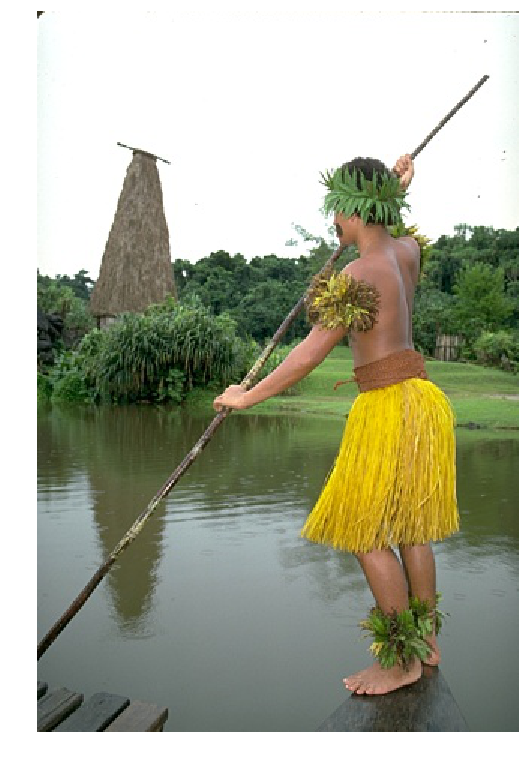

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fd4319c0e10>)

In [2]:
image = imageio.imread("data/101087.jpg")
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

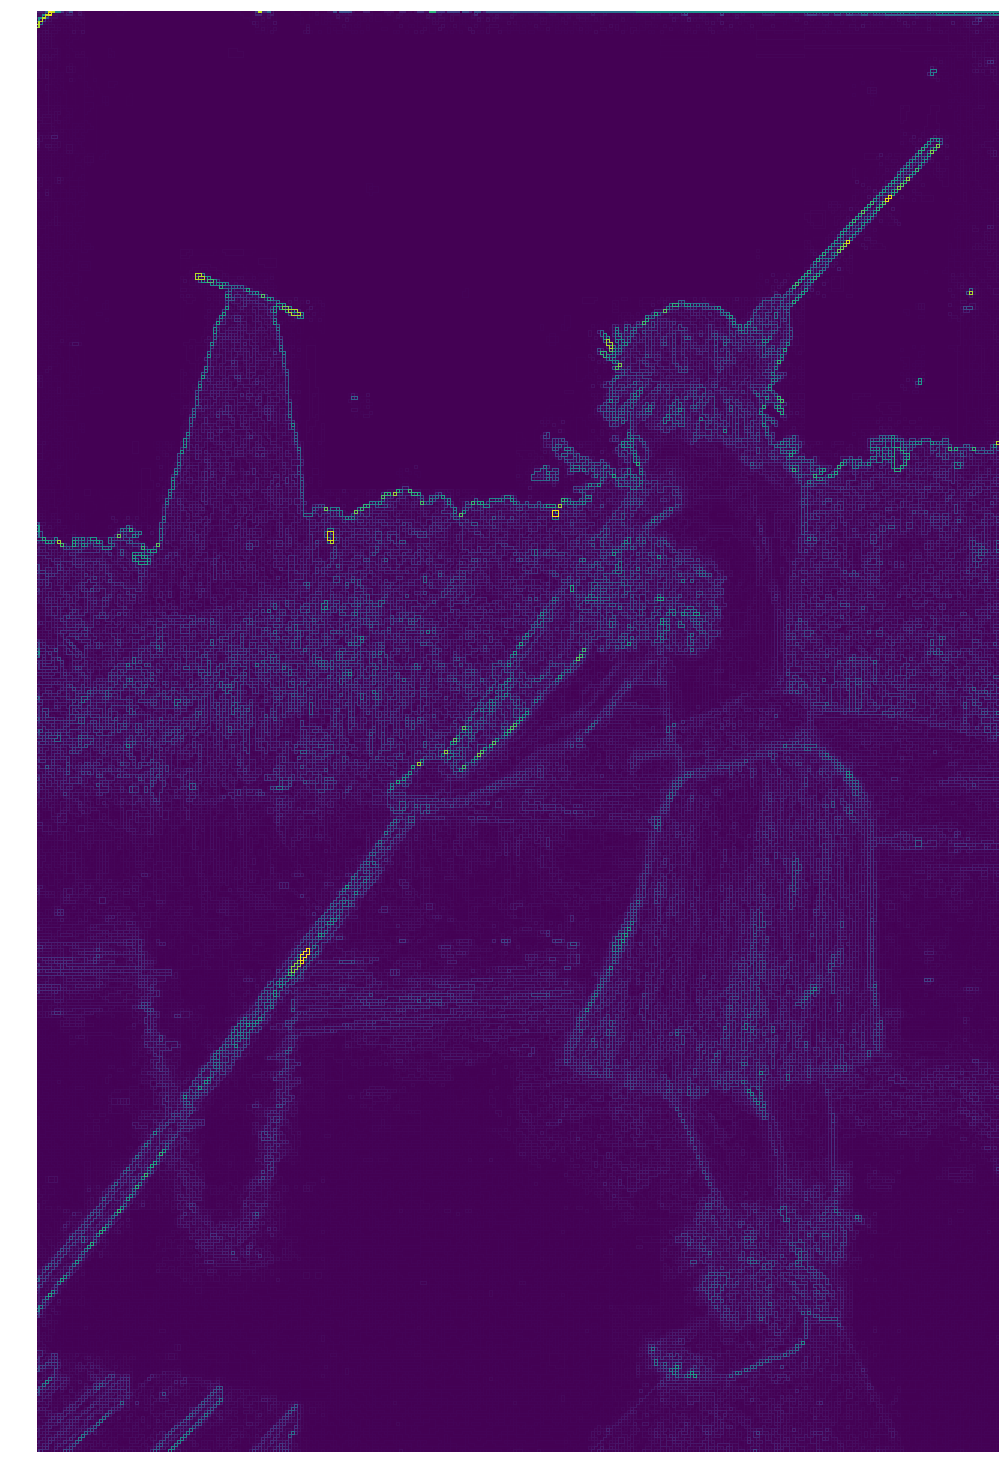

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fd43190a358>)

In [3]:
graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, image, hg.WeightFunction.L2)
tree, altitudes = hg.bpt_canonical(graph, edge_weights)
saliency = hg.saliency(tree, altitudes)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, saliency))

In [4]:
def area_filter_bpt(graph, saliency, area_threshold=50):
    # binary partition tree by altitude ordering (bpt)
    tree, altitudes = hg.bpt_canonical(graph, saliency)
    # get mst as a byproduct of previous function
    mst =  hg.CptBinaryHierarchy.get_mst(tree)
    # compute area of each node
    area = hg.attribute_area(tree)      
    # compute for each node the minimum of the area of its children
    min_area_children = hg.accumulate_parallel(tree, area, hg.Accumulators.min)    
    # identify nodes having a child whose area is too small
    deleted_frontier_nodes = min_area_children <= area_threshold  
    # the edge weights of the mst are the altitudes of the inner nodes of the bpt
    mst_edge_weights = altitudes[tree.num_leaves():]                    
    # set the edge weights of mst edges corresponding to identified nodes to 0
    mst_edge_weights[deleted_frontier_nodes[tree.num_leaves():]] = 0         
    # compute the bpt of the mst with the modified edge weights
    tree, altitudes = hg.bpt_canonical(mst, mst_edge_weights) 
    # return the saliency map corresponding to this last tree
    return hg.saliency(tree, altitudes)                                             

In [5]:
filtersm = area_filter_bpt(graph, saliency)

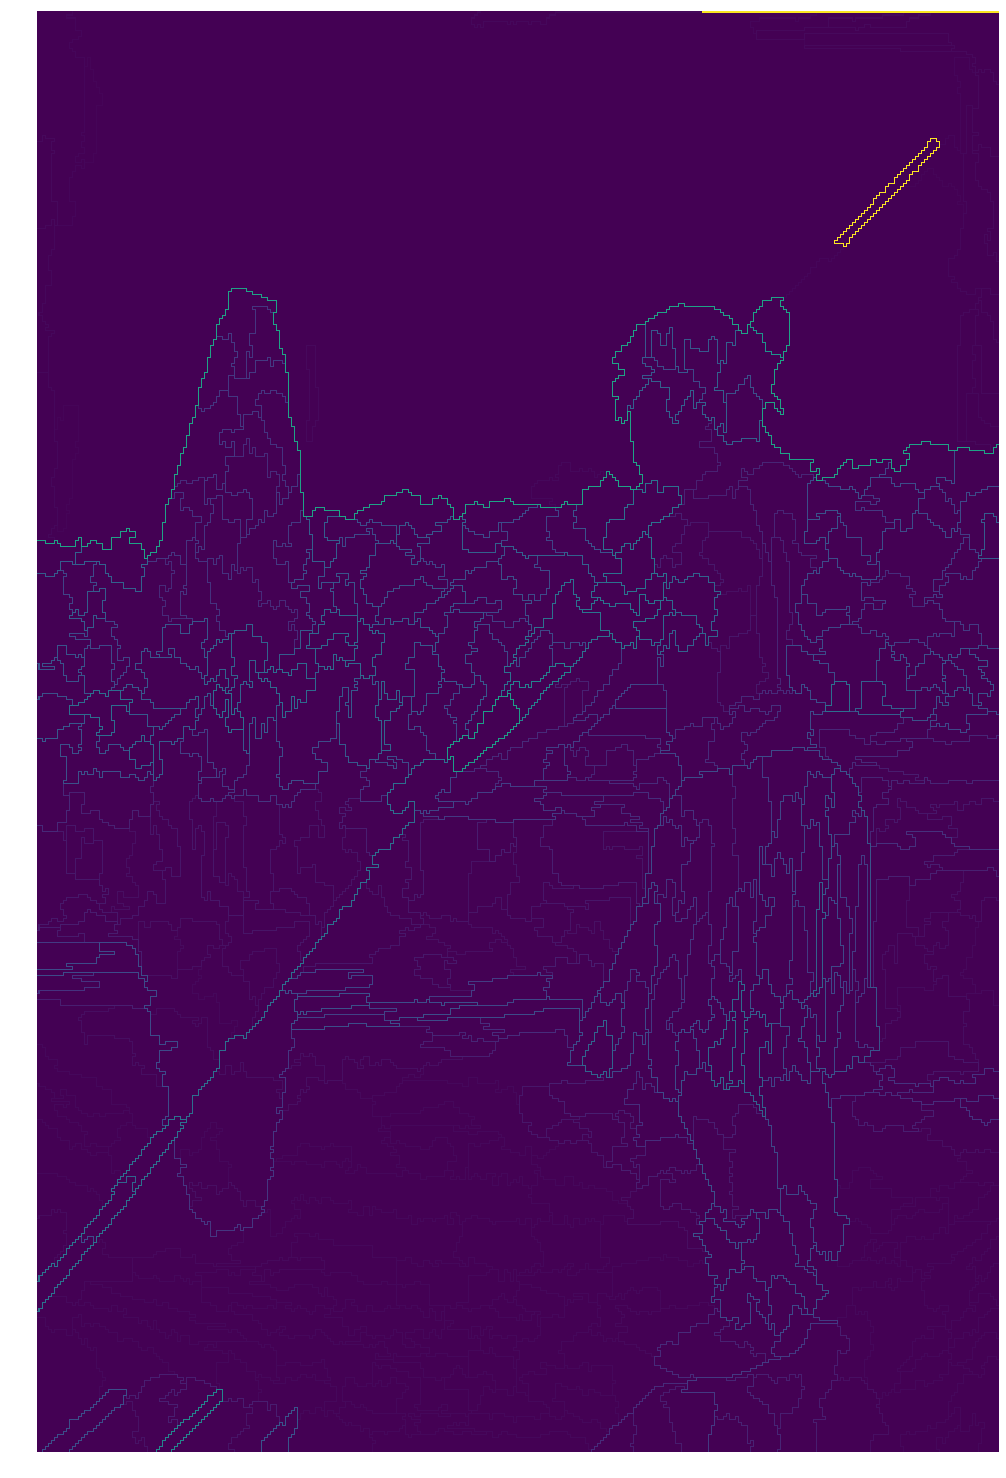

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fd431a2bbe0>)

In [6]:
imshow(hg.graph_4_adjacency_2_khalimsky(graph, filtersm))

In [7]:
def area_filter_qfz(graph, saliency, area_threshold=50):
    # compute the minimum spanning tree 
    mst = hg.minimum_spanning_tree(graph, saliency)        
    # get the correspondance between mst edges and the edges of the input graph
    mst_edge_map = hg.CptMinimumSpanningTree.get_edge_map(mst)            
    # deduce mst edge weights from the correspondance
    mst_edge_weights = saliency[mst_edge_map]                       
    # compute qfz on the weighted mst
    tree, altitudes = hg.quasi_flat_zones_hierarchy(mst, mst_edge_weights)     
    
    # get all the edges of the mst as two lists containing respectively the sources and the targets vertices
    sources, targets = mst.edge_list()                 
    # compute the largest region containing a source vertex with an altitude lower than the weight of its edge
    region_sources = tree.find_region(sources, mst_edge_weights, altitudes)    
    # compute the largest region containing a target vertex with an altitude lower than the weight of its edge
    region_targets = tree.find_region(targets, mst_edge_weights, altitudes)   
    
    # stack the regions of sources and targets to reform edges
    region_edges = np.vstack((region_sources, region_targets)) 
    # area of each node of the tree
    area = hg.attribute_area(tree)  
    # area of the found regions            
    area_nodes = area[region_edges] 
    # minimum of the area of the regions founds at the two extremities on an edge
    min_area_children = np.min(area_nodes,  axis=0)  
    
    # identify nodes having a child whose area is too small
    deleted_frontier_nodes = min_area_children <= area_threshold 
    # set the edge weights of mst edges corresponding to identified nodes to 0
    mst_edge_weights[deleted_frontier_nodes] = 0
    # compute the bpt of the mst with the modified edge weights
    tree, altitudes = hg.bpt_canonical(mst, mst_edge_weights)
    # return the saliency map corresponding to this last tree
    return hg.saliency(tree, altitudes)                                              

In [8]:
filtersm2 = area_filter_qfz(graph, saliency)

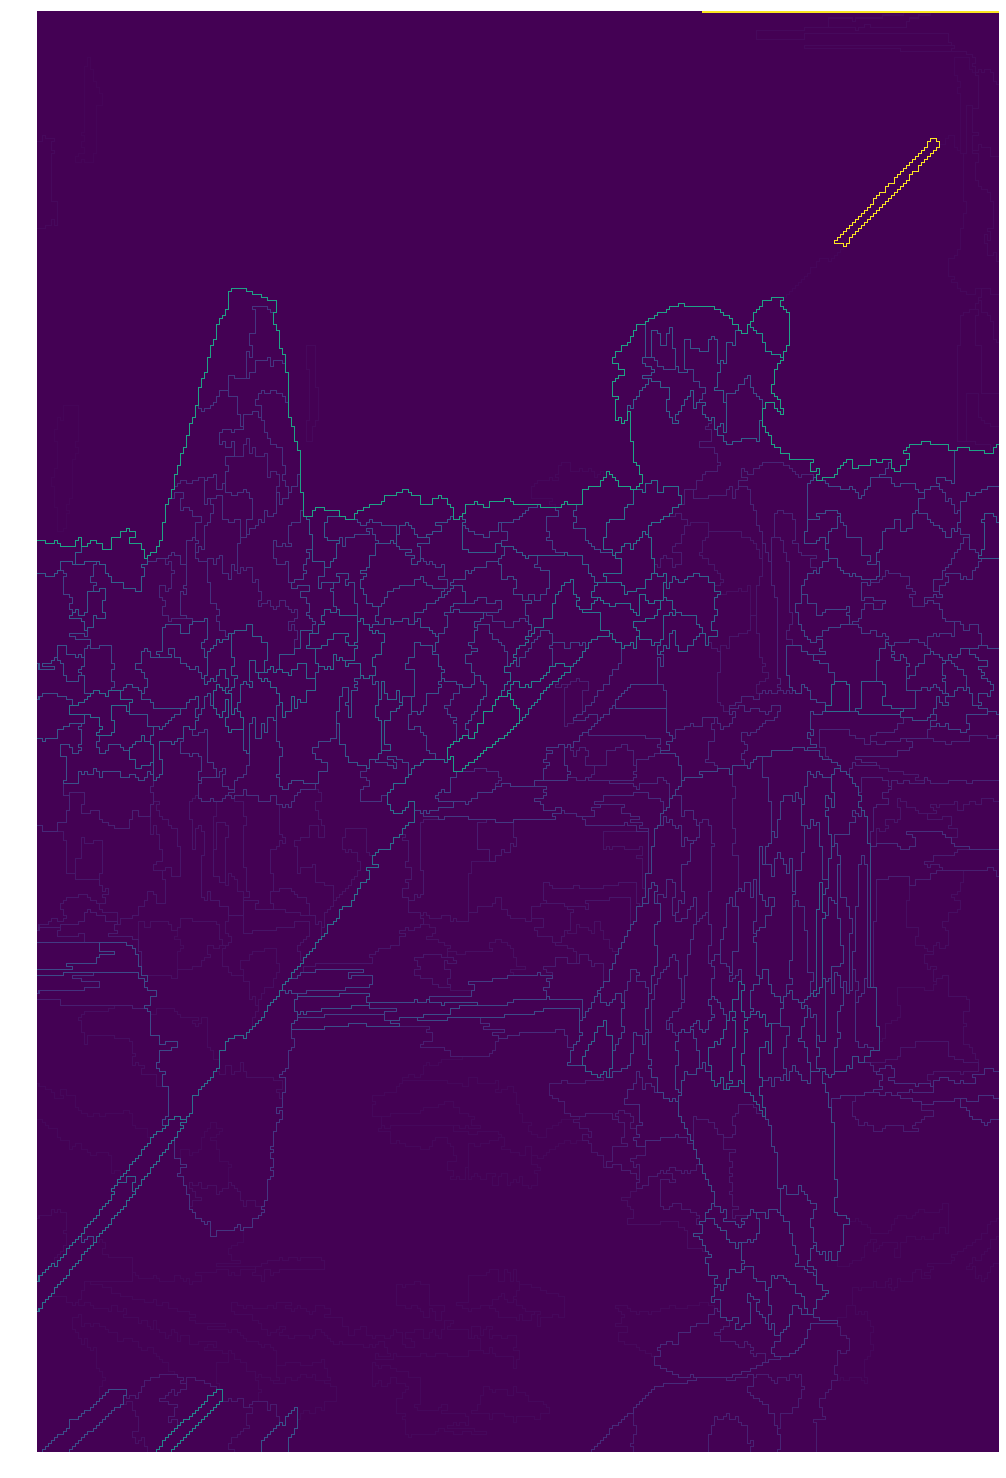

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fd43188d438>)

In [9]:
imshow(hg.graph_4_adjacency_2_khalimsky(graph, filtersm2))

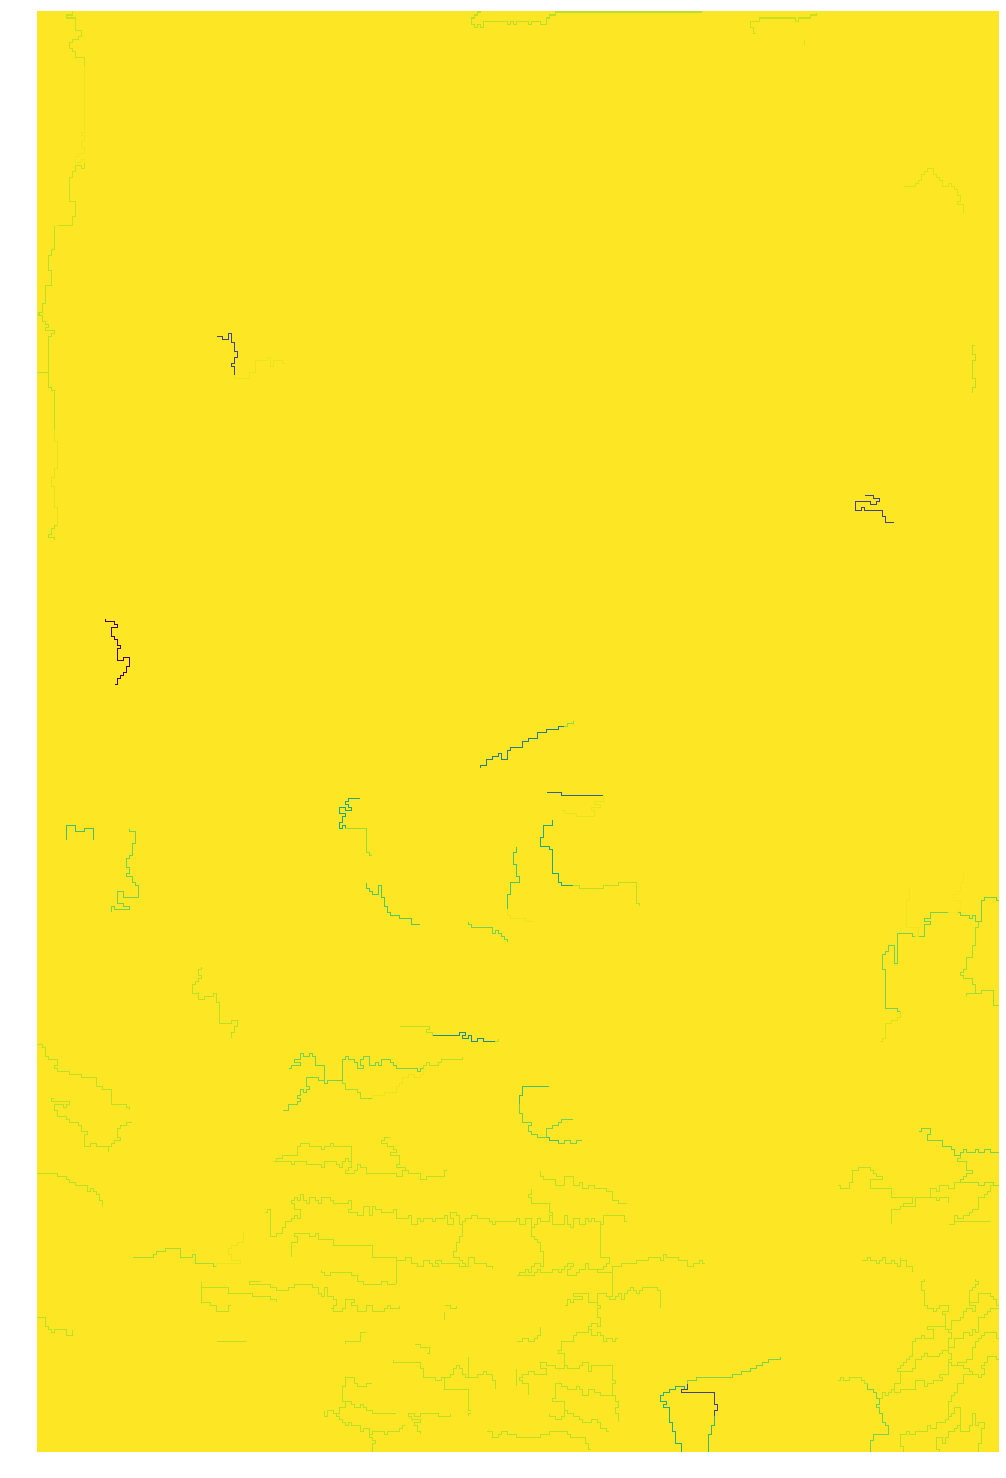

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fd4317f3780>)

In [10]:
imshow(hg.graph_4_adjacency_2_khalimsky(graph, filtersm2)-hg.graph_4_adjacency_2_khalimsky(graph, filtersm))

In [11]:
%timeit filtersm = area_filter_bpt(graph, saliency)

373 ms ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit filtersm2 = area_filter_qfz(graph, saliency)

294 ms ± 5.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%load_ext line_profiler

In [14]:
%lprun -f area_filter_bpt area_filter_bpt(graph, saliency)


In [15]:
%lprun -f area_filter_qfz area_filter_qfz(graph, saliency)